In [1]:
# Dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from modules.dataset import load_words, load_tweets
from modules.network import get_edges, get_degree

# Set up default colors
colors=[*mc.TABLEAU_COLORS.values()]

%matplotlib inline

# Dataset

In [2]:
# Load vocabularies for word (text, pos) nodes
w2i = np.load('data/edges_w2i.npy', allow_pickle=True).item()
i2w = np.load('data/edges_i2w.npy', allow_pickle=True).item()

In [3]:
# Load tweets dataset table
tweets = load_tweets('data/database/tweets.csv')

# Keep only tweet date and id
tweets = tweets[['created_at', 'id_str']]
tweets.columns = ('created_at', 'tweet')

# Add year month day columns
tweets['year'] = tweets.created_at.dt.year
tweets['month'] = tweets.created_at.dt.month
tweets['day'] = tweets.created_at.dt.day

# Create full numeric date
tweets['ymd'] = tweets.apply(lambda x: int('{:04d}{:02d}{:02d}'.format(x.year, x.month, x.day)), axis=1)

# Remove created_at column
del tweets['created_at']

# Show table
tweets.head()

,tweet,year,month,day,ymd
0,1013189209488797697,2018,6,30,20180630
1,1013143915308953606,2018,6,30,20180630
2,1013128815575470081,2018,6,30,20180630
3,1013098625768009728,2018,6,30,20180630
4,1013075989885341697,2018,6,30,20180630


In [4]:
# Load words dataset table
words = load_words('data/database/words.csv')
words = words[['tweet', 'index', 'text', 'pos']]

# Map word (test, pos) to node id
words['node'] = words.apply(lambda x: w2i[(x.text, x.pos)], axis=1)

# Join words with year-month-day information
words = pd.merge(words, tweets, on='tweet', how='left')
# Sort words in ascending order
words.sort_values(by=['year', 'month', 'day'], ascending=True, inplace=True)

# Show table
words.head()

,tweet,index,text,pos,node,year,month,day,ymd
4607,847985662850723840,1,participate,V,1567,2017,4,1,20170401
4608,847985662850723840,4,training,N,2303,2017,4,1,20170401
4609,847985662850723840,7,decide,V,553,2017,4,1,20170401
4610,847985662850723840,9,run,V,1949,2017,4,1,20170401
4611,847985662850723840,11,local,A,1288,2017,4,1,20170401


# Network

In [5]:
# Group words by tweet date

# Define container for each date's edgelist
edges_cumulative = list()

# Fill container with dataframes: one for every period
for (year, month, day, ymd), _ in words.groupby(by=['year', 'month', 'day', 'ymd']):
    # Select words whose month and day is lower or equal than the current one, but on the same year
    words_cumulative = words[(words.year == year) & (words.ymd <= ymd)]
    # Create edges for current day
    edges = get_edges(words_cumulative)
    # Add year, month, day columns to edges
    edges['year'] = year
    edges['month'] = month
    edges['day'] = day
    edges['ymd'] = ymd
    # Add edges to edgelist
    edges_cumulative.append(edges)
    
# Turn edgelists container into a single edgeslist DataFrame
edges = pd.concat(edges_cumulative, axis=0)
edges.head()

,node_x,node_y,weight,year,month,day,ymd
0,34,364,1,2017,4,1,20170401
1,34,2220,1,2017,4,1,20170401
2,113,1597,1,2017,4,1,20170401
3,122,240,1,2017,4,1,20170401
4,122,954,1,2017,4,1,20170401


In [6]:
# Create a network for every day
networks = { 2017: {} , 2018 : {} }
# Fill network dictionary
for (year, month, day), _ in edges.groupby(by=['year', 'month', 'day']):
    # Compute corresponding ymd code
    ymd = int('{:04d}{:02d}{:02d}'.format(year, month, day))
    # Create network from edgelist
    network = nx.from_pandas_edgelist(edges[edges.ymd == ymd], source='node_x', target='node_y', 
                                      edge_attr=True, create_using=nx.Graph)
    # Store network
    networks[year][(month, day)] = network

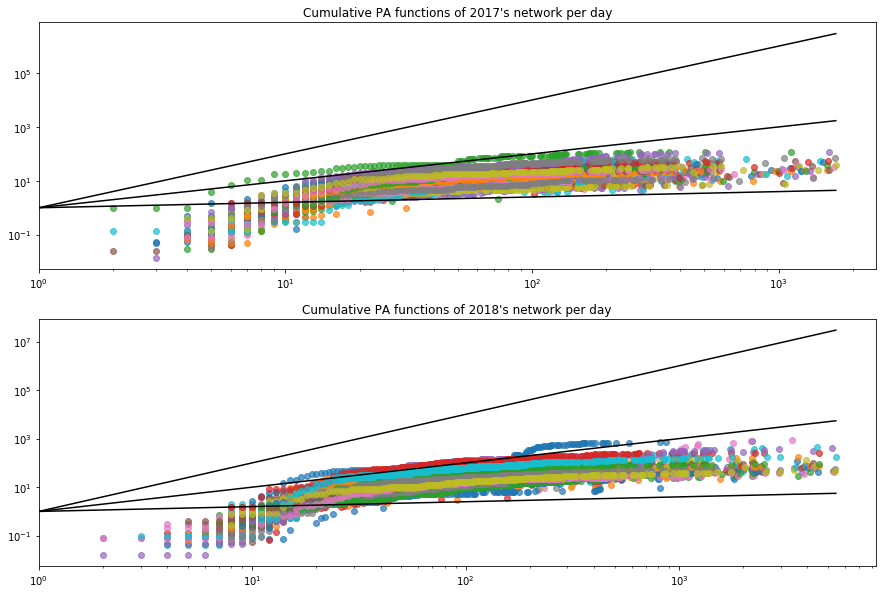

In [7]:
# Compute comulative preferential attachment function (cumulative pi)

# Define years list
years = [ 2017, 2018 ]

# Initialize figure
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for k, y in enumerate(years):
    # Define list of available days for each net
    days = list(networks[y].keys())
    
    # Set axis title
    _ = axs[k].set_title('Cumulative PA functions of {:d}\'s network per day'.format(y))
    
    for i in range(1, len(days)):
        # Initialize df of results
        pi = pd.DataFrame([])
        
        # Define old nodes list
        old_nodes = list(set(networks[y][days[i]].nodes) & set(networks[y][days[i-1]].nodes))
        # Compute initial degrees (ki_today)
        pi['ki'] = get_degree( networks[y][days[i]] ).loc[ old_nodes ] 
        # Compute pi function on old nodes: (ki_today - ki_yesterday) / time_interval
        pi_day = pi['ki'] - get_degree( networks[y][days[i-1]] )
        # time interval = num. new nodes
        pi['value'] = pi_day / ( len(networks[y][days[i]].nodes) - len(old_nodes) ) 
        # Sort pi entries by initial degree
        pi = pi.sort_values(by='ki')
        # Comupute cumulative pi
        cum_pi = np.cumsum([sum(pi[pi.ki == k].value) for k in pi.ki.unique()])
        
        # Plot 
        _ = axs[k].loglog(pi.ki.unique(), cum_pi, 'o', alpha=.7)
    # Plot reference lines
    _ = axs[k].loglog(np.arange(max(pi.ki)), np.arange(max(pi.ki))**2, color = 'black')
    _ = axs[k].loglog(np.arange(max(pi.ki)), np.arange(max(pi.ki)), color = 'black')
    _ = axs[k].loglog(np.arange(max(pi.ki)), np.arange(max(pi.ki))**.2, color = 'black')
    
# Set limits
axs[0].set_xlim(1)
axs[1].set_xlim(1)
# Show plot
_ = plt.show()

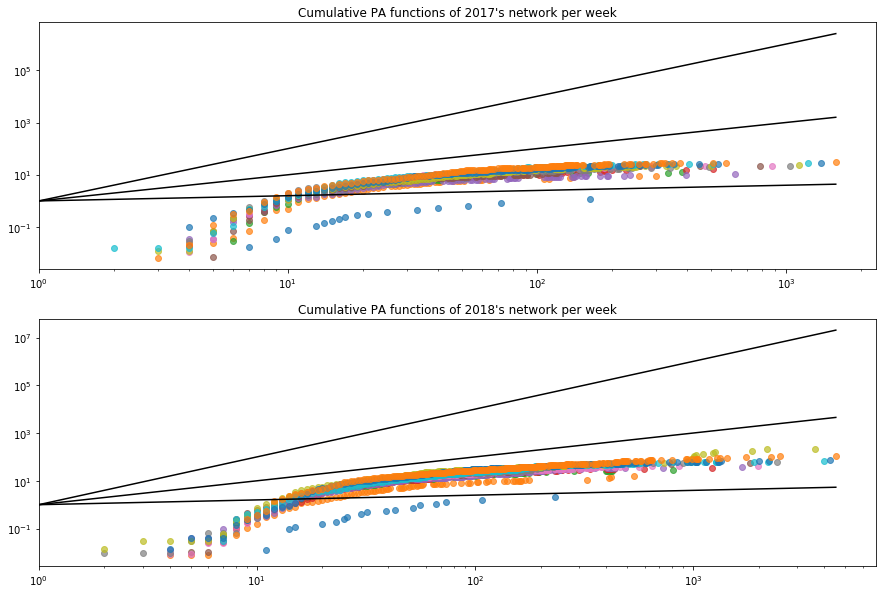

In [8]:
# Compute comulative preferential attachment function (cumulative pi)

# Define years list
years = [ 2017, 2018 ]

# Initialize figure
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for k, y in enumerate(years):
    # Define list of available days for each net
    days = list(networks[y].keys())
    
    # Set axis title
    _ = axs[k].set_title('Cumulative PA functions of {:d}\'s network per week'.format(y))
    
    for i in range(7,len(days),7):
        # Initialize df of results
        pi = pd.DataFrame([])
        
        # Define old nodes list
        old_nodes = list(set(networks[y][days[i]].nodes) & set(networks[y][days[i-7]].nodes))
        # Compute initial degrees (ki_today)
        pi['ki'] = get_degree( networks[y][days[i]] ).loc[ old_nodes ] 
        # Compute pi function on old nodes: (ki_today - ki_yesterday) / time_interval
        pi_day = pi['ki'] - get_degree( networks[y][days[i-7]] )
        # time interval = num. new nodes
        pi['value'] = pi_day / ( len(networks[y][days[i]].nodes) - len(old_nodes) ) 
        # Sort pi entries by initial degree
        pi = pi.sort_values(by='ki')
        # Comupute cumulative pi
        cum_pi = np.cumsum([sum(pi[pi.ki == k].value) for k in pi.ki.unique()])
        
        # Plot 
        _ = axs[k].loglog(pi.ki.unique(), cum_pi, 'o', alpha=.7)
    # Plot reference lines
    _ = axs[k].loglog(np.arange(max(pi.ki)), np.arange(max(pi.ki))**2, color = 'black')
    _ = axs[k].loglog(np.arange(max(pi.ki)), np.arange(max(pi.ki)), color = 'black')
    _ = axs[k].loglog(np.arange(max(pi.ki)), np.arange(max(pi.ki))**.2, color = 'black')
        
# Set limits
axs[0].set_xlim(1)
axs[1].set_xlim(1)
# Show plot
_ = plt.show()